In [13]:
# Imports
import numpy as np
import pandas as pd
%matplotlib widget
import matplotlib.pyplot as plt
from collections import deque, Counter
import networkx as nx   # For drawing the graphs
import torch
from torch_geometric.datasets import ZINC
from torch_geometric.utils import to_networkx


In [ ]:

# This will download (once) and then load the dataset into ./data/ZINC
dataset = ZINC(root="data/ZINC")

print(dataset)
print(f"Number of graphs: {len(dataset)}")

# Peek at the first graph
g = dataset[0]
print(g)
print("Node features shape:", g.x.shape)
print("Edge index shape:", g.edge_index.shape)
print("Edge attributes shape:", g.edge_attr.shape if g.edge_attr is not None else None)
print("Target y:", g.y)

print("First 5 node feature vectors:")
print(g.x[:5])

print("Unique rows in x for this graph:", torch.unique(g.x, dim=0).shape[0])
print("Num node features:", g.num_node_features)

num_nodes_list = []
num_edges_list = []

for i in range(100):  # sample subset
    g = dataset[i]
    num_nodes_list.append(g.num_nodes)
    num_edges_list.append(g.num_edges)

print("Avg nodes:", sum(num_nodes_list) / len(num_nodes_list))
print("Avg edges:", sum(num_edges_list) / len(num_edges_list))


ZINC(220011)
Number of graphs: 220011
Data(x=[33, 1], edge_index=[2, 72], edge_attr=[72], y=[1])
Node features shape: torch.Size([33, 1])
Edge index shape: torch.Size([2, 72])
Edge attributes shape: torch.Size([72])
Target y: tensor([3.0464])
First 5 node feature vectors:
tensor([[0],
        [0],
        [0],
        [0],
        [0]])
Unique rows in x for this graph: 4
Num node features: 1
Avg nodes: 23.43
Avg edges: 50.38


In [10]:
train_dataset = ZINC(root="data/ZINC", split="train")
val_dataset   = ZINC(root="data/ZINC", split="val")
test_dataset  = ZINC(root="data/ZINC", split="test")

print(len(train_dataset), len(val_dataset), len(test_dataset))


220011 24445 5000


In [11]:

def visualize_zinc_molecule(dataset, idx, with_labels=True, node_size=400):
    """
    Visualize a single ZINC molecule as a graph.

    Parameters
    ----------
    dataset : torch_geometric.datasets.ZINC
        The dataset you loaded.
    idx : int
        Index of the molecule in the dataset.
    with_labels : bool
        If True, show the atom_type index as a label on each node.
    node_size : int
        Size of the drawn nodes.
    """
    data = dataset[idx]          # PyG Data object for one molecule
    G = to_networkx(data, to_undirected=True)

    # data.x is shape [num_nodes, 1] with atom_type indices
    atom_types = data.x.squeeze().cpu().numpy()  # -> [num_nodes]

    # Layout for plotting (spring layout for generic graphs)
    pos = nx.spring_layout(G, seed=0)

    plt.figure(figsize=(4, 4))

    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.5)

    # Draw nodes, colored by atom_type index
    nodes = nx.draw_networkx_nodes(
        G,
        pos,
        node_size=node_size,
        node_color=atom_types,
        cmap="viridis",
    )

    # Optional colorbar to see atom_type codes
    cbar = plt.colorbar(nodes, shrink=0.7)
    cbar.set_label("atom_type index")

    # Optional labels on each node (the integer atom_type)
    if with_labels:
        labels = {i: int(atom_types[i]) for i in range(data.num_nodes)}
        nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)

    plt.title(f"ZINC molecule #{idx}")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


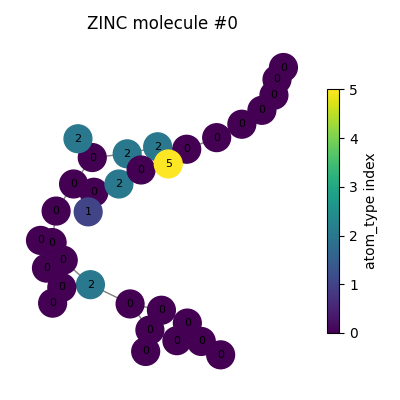

In [24]:
visualize_zinc_molecule(dataset, 0) # 0 - 220010

In [22]:

def inspect_zinc_graph(dataset, idx=0, max_nodes_to_print=10, max_edges_to_print=10):
    """
    Print detailed information about a single ZINC molecule from a PyG dataset.
    
    Parameters
    ----------
    dataset : torch_geometric.datasets.ZINC
        Loaded ZINC dataset.
    idx : int
        Index of the molecule within this dataset.
    max_nodes_to_print : int
        Max number of node feature rows to print explicitly.
    max_edges_to_print : int
        Max number of edges (with attributes) to print explicitly.
    """
    data = dataset[idx]
    print(f"=== Molecule #{idx} ===")
    print(data)  # PyG's summary: x, edge_index, edge_attr, y

    # Basic sizes
    print("\n--- Shapes ---")
    print(f"num_nodes:        {data.num_nodes}")
    print(f"num_edges:        {data.num_edges}")      # directed edges in edge_index
    print(f"x shape:          {tuple(data.x.shape)}")  # [num_nodes, num_node_features]
    print(f"edge_index shape: {tuple(data.edge_index.shape)}")
    if data.edge_attr is not None:
        print(f"edge_attr shape: {tuple(data.edge_attr.shape)}")
    else:
        print("edge_attr:        None")
    print(f"y (target) shape: {tuple(data.y.shape)}")
    print(f"y (value):        {data.y.item():.4f}")

    # Node features (atom_type indices)
    print("\n--- Node features (data.x) ---")
    print(f"dtype: {data.x.dtype}")
    num_node_features = data.num_node_features
    print(f"num_node_features: {num_node_features}")

    # Print first few rows
    print(f"\nFirst {min(max_nodes_to_print, data.num_nodes)} node feature vectors:")
    print(data.x[:max_nodes_to_print])

    # Unique feature rows and counts
    x_cpu = data.x.cpu()
    unique_rows, inverse = torch.unique(x_cpu, dim=0, return_inverse=True)
    counts = Counter(inverse.tolist())

    print(f"\nNumber of distinct node feature patterns in this molecule: {len(unique_rows)}")
    for i, row in enumerate(unique_rows):
        print(f"  pattern #{i}: feature = {row.tolist()}  count = {counts[i]}")

    # Interpret atom_type if x is just an index
    if num_node_features == 1:
        atom_type_indices = x_cpu.squeeze()
        print("\nAtom-type index distribution in this molecule:")
        atom_counter = Counter(atom_type_indices.tolist())
        for atom_type, c in sorted(atom_counter.items()):
            print(f"  atom_type {atom_type}: {c} atoms")

    # Edge information
    print("\n--- Edges (data.edge_index, data.edge_attr) ---")
    ei = data.edge_index
    ea = data.edge_attr

    print(f"First {min(max_edges_to_print, ei.shape[1])} edges with attributes:")
    for e_idx in range(min(max_edges_to_print, ei.shape[1])):
        u = int(ei[0, e_idx])
        v = int(ei[1, e_idx])
        if ea is not None:
            bond_type = int(ea[e_idx])
            print(f"  edge {e_idx}: {u} -> {v}, bond_type_idx = {bond_type}")
        else:
            print(f"  edge {e_idx}: {u} -> {v}")

    if ea is not None:
        ea_cpu = ea.cpu()
        unique_bonds, bond_counts = torch.unique(ea_cpu, return_counts=True)
        print("\nBond-type index distribution in this molecule:")
        for bt, c in zip(unique_bonds.tolist(), bond_counts.tolist()):
            print(f"  bond_type {bt}: {c} directed edges")


In [23]:
inspect_zinc_graph(dataset, idx=0)

=== Molecule #0 ===
Data(x=[33, 1], edge_index=[2, 72], edge_attr=[72], y=[1])

--- Shapes ---
num_nodes:        33
num_edges:        72
x shape:          (33, 1)
edge_index shape: (2, 72)
edge_attr shape: (72,)
y (target) shape: (1,)
y (value):        3.0464

--- Node features (data.x) ---
dtype: torch.int64
num_node_features: 1

First 10 node feature vectors:
tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [2],
        [2],
        [0]])

Number of distinct node feature patterns in this molecule: 4
  pattern #0: feature = [0]  count = 26
  pattern #1: feature = [1]  count = 1
  pattern #2: feature = [2]  count = 5
  pattern #3: feature = [5]  count = 1

Atom-type index distribution in this molecule:
  atom_type 0: 26 atoms
  atom_type 1: 1 atoms
  atom_type 2: 5 atoms
  atom_type 5: 1 atoms

--- Edges (data.edge_index, data.edge_attr) ---
First 10 edges with attributes:
  edge 0: 0 -> 1, bond_type_idx = 1
  edge 1: 1 -> 0, bond_type_

In [ ]:
def weisfeiler_leman():
    pass